# Introduction to Machine Learning - PROJECT

Authors: Aino Liukkonen and Raúl Cruz-Oliver

In [329]:
%reset -f

import pandas as pd
# Documentation
# https://pandas.pydata.org/docs

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import statsmodels.api as sm
import itertools
%matplotlib inline

## TEST EXAMPLE

In [330]:
# Our respective DATA folder paths
#data_folder = r'C:\Users\lenovo\Desktop\S7-DE\Introduction to Machine Learning\machine_learning_project\DATA'
data_folder = r'C:\Users\ainol\OneDrive\Tiedostot\TutaJaOhtu\Machine_Learning\course_project\DATA'

# Import Data
test = pd.read_excel(data_folder + r'\test.xlsx') #once we define the folder, the path is the same



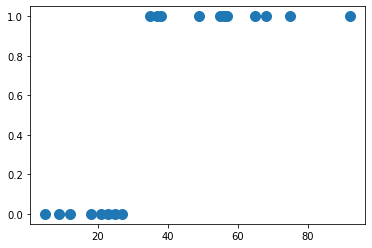

In [331]:
# Data visualization

# from data to vector
#x = test["Age"].to_numpy()
#y = test["Children"].to_numpy()


x = test["Age"].array
y = test["Children"].array



plt.scatter(x, y)

In [332]:
k = 1   #number of predictors, remember theta_0 is for the bias since x_o is always 1

sh=np.shape(x)
m=sh[0] #number of observations in the training data

#x=np.reshape(x, (m,1)) #predictors
x = x.reshape(-1, 1) 

#y=np.reshape(y, (m,1)) #labels
y = y.reshape(-1, 1) 

ones = np.ones ((m,1)) #for the bias x_0

X = np.concatenate((ones,x),axis=1) #matrix of training data

theta = np.random.rand(k+1,1)

#print(theta)
#print(X)

In [333]:
# logistic training

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_train(theta,X,y):   
    epsilon=1.0E-03
    alpha=0.1
    diff=epsilon+1
    theta_old=theta
    c=0
    while diff > epsilon:
        theta_old=theta
        error=sigmoid(np.dot(X,theta))-y
        theta = theta_old - (alpha/m)*np.dot(np.transpose(X),error)
        diff = np.linalg.norm(theta_old-theta)
        c=c+1
        if c == 10000:
            return theta
    return theta

theta=logistic_train(theta,X,y)    


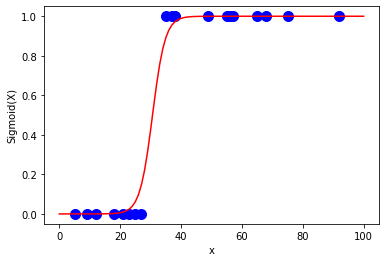

In [334]:
#trained model visualization
x_graph = np.linspace(0, 100, 101)
x_graph=np.reshape(x_graph, (101,1)) #predictors
ones = np.ones ((101,1)) #for the bias x_0
X_graph = np.concatenate((ones,x_graph),axis=1) #matrix of training data

z_graph = sigmoid(np.dot(X_graph,theta))

plt.plot(x_graph, z_graph, c="red")
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
x = test["Age"].to_numpy()
y = test["Children"].to_numpy()
plt.scatter(x, y, c="blue")

In [335]:
#PREDICTION

threshold = 0.5 #limit where sth is clasify as 1 and not anymore as 0

y_predict = sigmoid(np.dot(X,theta))

y_p = np.zeros(m)

for i in range(1,m):
    if y_predict[i]>threshold:
        y_p[i]=1
        
print(y)
print(y_p)
        
#y labelling
#y_predict return from the sigmoid
#y_p prediction based on a fixed threshold


[0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0]
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]


In [336]:
#EVALUATING THE MODEL

#F-MEASURE
print("F-measure:" , metrics.f1_score(y,y_p))
#the closer to 1, the better the performance is

#K-STATISTIC
print("Kappa:",metrics.cohen_kappa_score(y, y_p))
#the closer to 1, the better the performance is

#AREA UNDER CURVE (AUC), FROM RECEIVING OPERATION CHARACTERISTIC (ROC)
print("AUC:",metrics.roc_auc_score(y,y_p))
# if AUC>0.5 it means the classificator is better than a random process. Perfect classificator <=> AUC=1

#other metrics
print(metrics.classification_report(y,y_p))

F-measure: 1.0
Kappa: 1.0
AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



## ACTUAL DATA IMPORT AND PREPROCESS

In [337]:
# Read data from LOSS.mat
mat_loss = loadmat(data_folder + r'\LOSS.mat')
loss_matrix = mat_loss['LOSS']
loss_matrix = np.matrix(loss_matrix)
#select only the first  rows
loss_matrix = loss_matrix[0:900,:] #trying to take balance data somehow
# Convert into a Pandas Data Frame
loss = pd.DataFrame(loss_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])

# Read data from PAY.mat
mat_pay = loadmat(data_folder + r'\PAY.mat')
pay_matrix = mat_pay['PAY']
pay_matrix = np.matrix(pay_matrix)
#select only the first rows
pay_matrix = pay_matrix[0:900,:] #trying to take balance data somehow
# Convert into a Pandas Data Frame
pay = pd.DataFrame(pay_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])


# Adding a column to the DataFrames
# the value of the column represents whether the mortgage has been paid back or defaulted
loss['is_paid'] = 0
pay['is_paid'] = 1

# Concatenate pay and loss data into one DataFrame
data_frames = [pay, loss]
pay_loss_not_stand = pd.concat(data_frames)


#What follows is the first way i founded to standarize the data
#it is MANDATORY to do it all together with loss and pay
#doing so, the is_paid column standarizes to -1,1, the code below just turn -1 to 0
#i'd rather use 0 instead of -1 since the code is already desing for that label
#probably there is more efficient way to code it

scaler = StandardScaler()
pay_loss_standarized = scaler.fit_transform(pay_loss_not_stand) 

print(pay_loss_standarized.shape)

pay_loss_STAND = pd.DataFrame(pay_loss_standarized, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR','is_paid'])

PAY_CORRECT=pay_loss_STAND['is_paid']==1
LOSS_CORRECT=pay_loss_STAND['is_paid']==-1

filtered_PAY = pay_loss_STAND[PAY_CORRECT]
filtered_LOSS = pay_loss_STAND[LOSS_CORRECT]

filtered_LOSS['is_paid']=0

data_frames = [filtered_PAY, filtered_LOSS]
pay_loss = pd.concat(data_frames)
        
# Adding a column to the DataFrames for the independent bias x_o in the literature
pay_loss['BIAS']=1


(1800, 18)


C:\Users\ainol\AppData\Local\Temp/ipykernel_2344/1195284201.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_LOSS['is_paid']=0


In [338]:
# Split data into training and validation sets
# Training data 70 %, validation data 30 %
train_data, validation_data = model_selection.train_test_split(pay_loss, test_size=0.3) #automatically shuffle

#NOTE: the shuffle is not considering the imbalanced data, maybe:
    #1. reuse the 0 to balance the data
    #2. divide the data taking into account the imbalance. e.g. 30% total = 30%pay + 30%loss. 
    #this idea would be also interesting to implement in the k-fold

#intially implemented without taking care of this -> LET'S SEE WHAT HAPPENS
    
#within the training data, k-fold cross validation will be implemented to select the best parameters
#validation set is only used to assess the model, no to select parameters

In [339]:
#Input vector and labelling

train_x = train_data[['BIAS','NOI', 'DSCR', 'LTV', 'Balance', 
                    'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                    'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                    'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR']].to_numpy() #already proper shape
train_y = train_data['is_paid'].to_numpy()
train_y = train_y.reshape(-1, 1)    

valid_x = validation_data[['BIAS','NOI', 'DSCR', 'LTV', 'Balance', 
                    'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                    'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                    'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR']].to_numpy() #already proper shape
valid_y = validation_data['is_paid'].to_numpy()
valid_y = valid_y.reshape(-1, 1)    


## BIVARIATE RELATIONSHIPS BETWEEN VARIABLES
TODO: Add small explanations and present the units of the data in the plots

Text(0, 0.5, 'NOI Ratio')

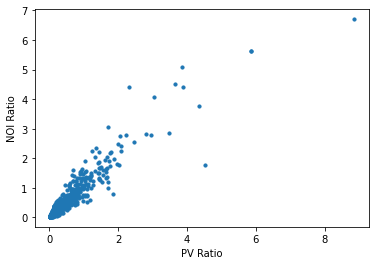

In [340]:
#plt.scatter(pay_loss.Year_Built, pay_loss.IR)
#plt.scatter(pay_loss.ZipPop, pay_loss.CS)
plt.scatter(pay_loss_not_stand.PV_Ratio, pay_loss_not_stand.NOI_Ratio, s=10)
plt.xlabel('PV Ratio')
plt.ylabel('NOI Ratio')

Text(0, 0.5, 'CR')

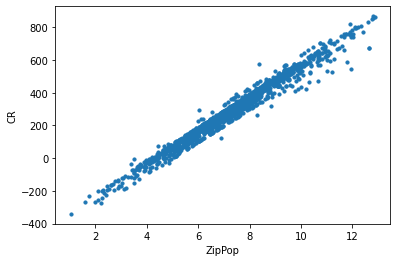

In [341]:
plt.scatter(pay_loss_not_stand.ZipPop, pay_loss_not_stand.CR, s=10)
plt.xlabel('ZipPop')
plt.ylabel('CR')

Text(0, 0.5, 'Balance ($)')

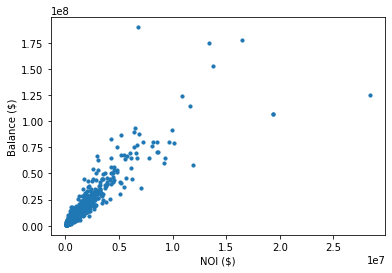

In [361]:
plt.scatter(pay_loss_not_stand.NOI, pay_loss_not_stand.Balance, s=10)
plt.xlabel('NOI ($)')
plt.ylabel('Balance ($)')
# plt.scatter(pay_loss.NOI, pay_loss.NOI_Ratio) <--- obviously correlated
# plt.scatter(pay_loss.Balance, pay_loss.NOI_Ratio) <--- also obviously correlated

Text(0, 0.5, 'PV Ratio')

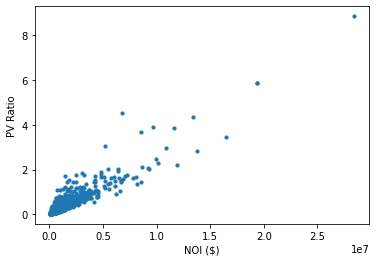

In [362]:
plt.scatter(pay_loss_not_stand.NOI, pay_loss_not_stand.PV_Ratio, s=10)
plt.xlabel('NOI ($)')
plt.ylabel('PV Ratio')
# --> plt.scatter(pay_loss.Balance, pay_loss.PV_Ratio)  
# and plt.scatter(pay_loss.PV_Ratio, pay_loss.NOI_Ratio) also correlated

Text(0, 0.5, 'Net Mortgage Rate')

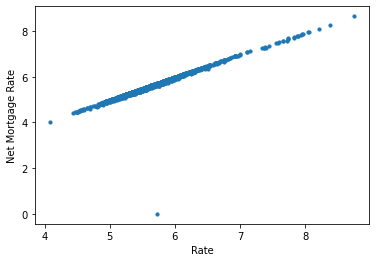

In [344]:
plt.scatter(pay_loss_not_stand.Rate, pay_loss_not_stand.Net_Mortgage_Rate, s=10)
plt.xlabel('Rate')
plt.ylabel('Net Mortgage Rate')

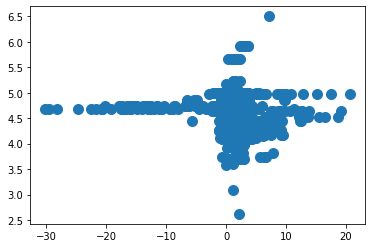

In [345]:
# For whatever reason, these do (still) not appear linearly correlated (!!?)
# REMOVE FROM THE ACTUAL PROJECT
plt.scatter(pay_loss_not_stand.CS, pay_loss_not_stand.CS_Ratio)

## IMPLEMENTATION OF THE LOGISTIC REGRESSION WITH THE ACTUAL DATA.
All predictors initially (k=17)

In [346]:
#TRAINING WITH K-FOLD CROSS VALIDATION FOR PARAMETER SELECTION

kf = KFold(n_splits=5)

#print(kf)

#print(kf.split(X))

k=17; # DO IT AUTOMATICALLY, related with the number of predictors=number of columns apart from labelling or bias term
threshold = 0.5

for train_index, test_index in kf.split(train_x):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_folded, X_test = train_x[train_index], train_x[test_index]
    y_train_folded, y_test = train_y[train_index], train_y[test_index]
    #model training and evaluation for every fold
    theta = np.random.rand(k+1,1)
    theta=logistic_train(theta,X_train_folded,y_train_folded)    
    y_p = sigmoid(np.dot(X_test,theta))
    #print(y_p.shape) to discover the 252
    y_predict = np.zeros(252) #252 comes from size of test data, to be automated
    for i in range(1,252): #this is just to control the threshold, no extrictly needed
        if y_p[i]>threshold:
            y_predict[i]=1
    print("AUC:",metrics.roc_auc_score(y_test,y_predict))
    

AUC: 0.7872689420225853
AUC: 0.7522869219607595
AUC: 0.7418897637795275
AUC: 0.7772177419354839
AUC: 0.7691628288436061


# CONCLUSION: 
my classificator is pretty shitty, but at least it classify things

AUC need to be at leat around 0.7 for logistic regresion, the professor got that in his paper.

now, we are around 0.5, or even worse, meaning that that a random even a random clasifier will perform better. :(

## SELECTION OF THE MOST RELEVANT VARIABLES

This information may be relevant
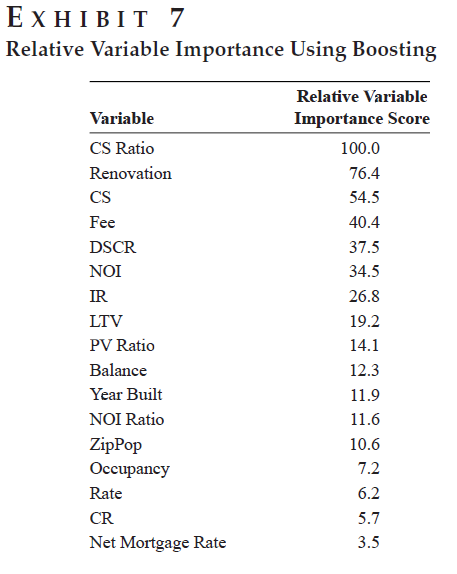 

## Forward and Backward Stepwise Regression

These need some adjusting, and I haven't quite figured out yet why my custom-made function selects different columns in
backward selection than SequentialFeatureSelection. (Related to the use of random forest classifier with SequentialFeatureSelection?)

In [347]:
# Backward stepwise Regression
# Build a Random Forest classifier for the feature selection
# DELETE BIAS FROM THE USED COLUMNS
# (Use a different model in the final version?) --> SVM & ROC_AUC
svm = SVC()

backward_feature_selection = sfs(svm,
                                forward=False,
                                floating=False,
                                verbose=2,
                                scoring='roc_auc',
                                cv=5)

x = train_x
np.delete(x, 0) # train_x includes a column for bias at index 0. Do not use this column for feature selection.
backward_feature_selection = backward_feature_selection.fit(x, train_data['is_paid'].to_numpy()) # train_y as a 1d vector

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.5s finished

[2022-02-22 09:52:26] Features: 17/1 -- score: 0.8826249726720669[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.9s finished

[2022-02-22 09:52:30] Features: 16/1 -- score: 0.8849430194241593[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.0s finished

[2022-02-22 09:52:34] Features: 15/1 -- score: 0.8860894602460405[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [348]:
# Print out the selected features
# WILL PLOT + EXAMINE THE RESULTS
# Plotting idea:
# https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b
feat_columns = list(backward_feature_selection.k_feature_idx_)
print("SELECTED COLUMNS:", feat_columns)

SELECTED COLUMNS: [14]


In [359]:
# Forward stepwise selection
svm = SVC()

forward_feature_selection = sfs(svm,
                                forward=True,
                                floating=False,
                                verbose=2,
                                scoring='roc_auc',
                                k_features=17,
                                cv=5)

x = train_x
np.delete(x, 0) # train_x includes a column for bias at index 0. Do not use this column for feature selection.
forward_feature_selection = forward_feature_selection.fit(x, train_data['is_paid'].to_numpy()) # train_y as a 1d vector

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   12.0s finished

[2022-02-22 10:26:08] Features: 1/17 -- score: 0.8095697033902507[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.5s finished

[2022-02-22 10:26:14] Features: 2/17 -- score: 0.8669407677214951[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.1s finished

[2022-02-22 10:26:17] Features: 3/17 -- score: 0.8875448787155573[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [350]:
# Print out the selected features
feat_columns = list(forward_feature_selection.k_feature_idx_)
print("SELECTED COLUMNS:", feat_columns)

SELECTED COLUMNS: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17]


## Best Subset Selection

In [376]:
# Best subset selection for a specific number of predictors k
def get_best(k, X, y):
    results = []

    # For each combination with a specific k value
    for combo in itertools.combinations(X.columns, k):
        svm = SVC()
        model = svm.fit(X[list(combo)], y)
        predY_svm = svm.predict(X[list(combo)])
        # Calculate AUC for the model
        auc = metrics.accuracy_score(y, predY_svm)
        results.append({'model':model, 'AUC':auc})
        print(".", end="") # Please ignore, just wanted to see the progress

    models = pd.DataFrame(results)
    # The best model is the one with the smallest RSS
    best_model = models.loc[models['AUC'].argmax()]

    return best_model

In [377]:
# SHOULD PROBABLY USE SCALED/NORMALIZED VALUES!?
# Problem with the huge amount of cases 
# (yes, printing the progress costs a lot of extra time, but needed to make sure the function is not stuck)
X = train_data.drop(['BIAS', 'is_paid'], axis=1)
y = train_data.is_paid

# Call the get_best() function for each number of predictors k
best_models = pd.DataFrame(columns = ['model', 'AUC'])
for i in range(1, 18):
    print("\n",i)
    best_models.loc[i] = get_best(i, X, y)


 1
.................
 2
........................................................................................................................................
 3
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
 4
.......................................................................................................................................................

KeyboardInterrupt: 

Text(0, 0.5, 'BIC')

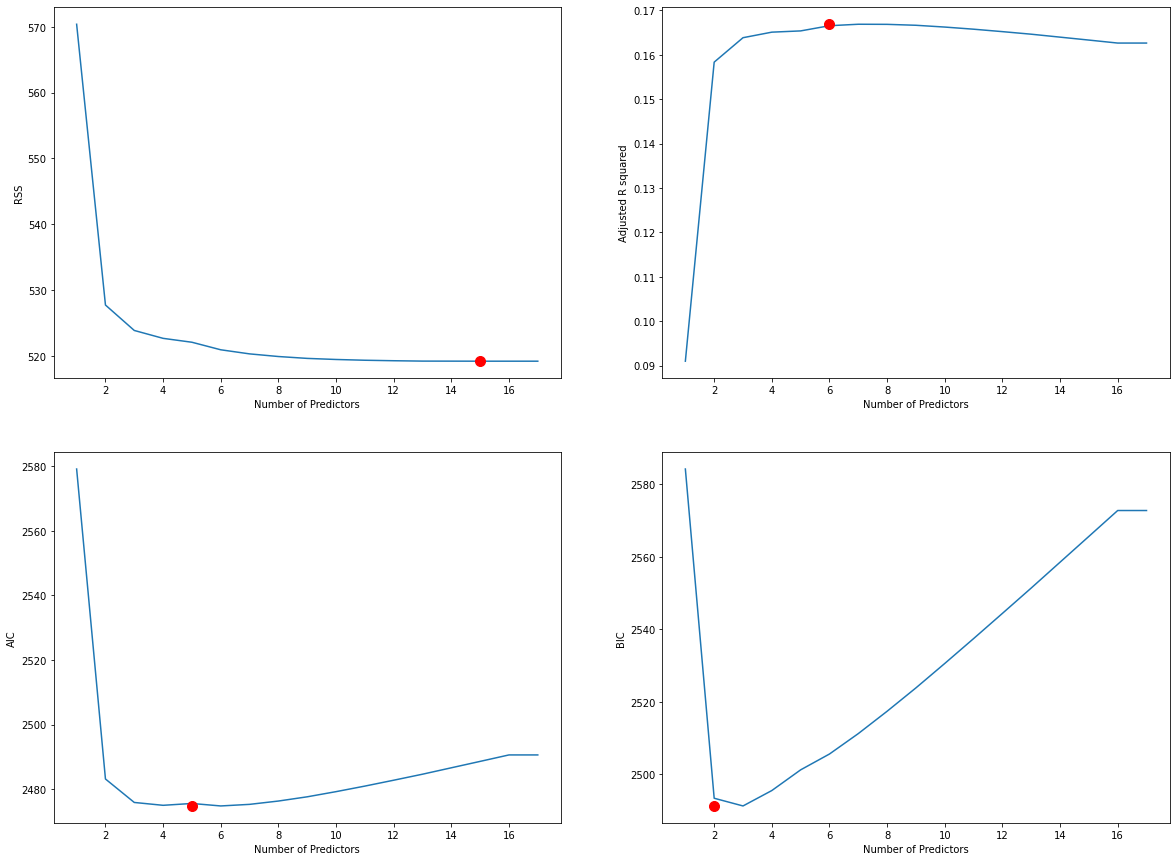

In [355]:
# Plotting the best subset selection process in order to find the best model
# NEEDS TO BE ADJUSTED FOR THE MODIFIED BEST MODEL SELECTION

plt.figure(figsize=(20,15))

# Set up a 2x2 grid for the plots so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# Plot RSS
plt.plot(best_models['RSS'])
plt.plot(best_models['RSS'].argmin(), best_models['RSS'].min(), 'or')
plt.xlabel('Number of Predictors')
plt.ylabel('RSS')

# Plot adjusted R squared
rsquared_adj = best_models.apply(lambda row: row[0].rsquared_adj, axis=1)
plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), 'or')
plt.xlabel('Number of Predictors')
plt.ylabel('Adjusted R squared')

# Plot AIC
aic = best_models.apply(lambda row: row[0].aic, axis=1)
plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), 'or')
plt.xlabel('Number of Predictors')
plt.ylabel('AIC')

# Plot BIC
bic = best_models.apply(lambda row: row[0].bic, axis=1)
plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), 'or')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')